# Relax Inc. Take-Home Challenge

Relax Inc. makes productivity and project management software that's popular with both individuals and teams. Founded by several former Facebook employees, it's considered a great company to work for.

## Part 1 ‐ Exploratory data analysis

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven day  period ,  identify  which  factors  predict  future  user
adoption .

### Imports

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7.5)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier 

### Data Cleaning

In [2]:
df_engagement = pd.read_csv('raw_data/takehome_user_engagement.csv')
df_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
df_users = pd.read_csv('raw_data/takehome_users.csv', encoding='latin-1')
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
print('Types:')
print(df_engagement.dtypes)

Types:
time_stamp    object
user_id        int64
visited        int64
dtype: object


In [5]:
# Convert time_stamp series to datetime and drop visited
df_engagement['time_stamp'] = pd.to_datetime(df_engagement['time_stamp'])
df_engagement.drop(['visited'], axis=1, inplace=True)

In [6]:
# Group users
grouped_users = pd.DataFrame(df_engagement.groupby('user_id')['time_stamp'].apply(list))
grouped_index = list(grouped_users.index)
grouped_timestamps = list(grouped_users['time_stamp'])

In [7]:
# Create function
def is_adapted(timestamps):
    '''Takes in a list of datetimes and returns 1 if the user is adapted, 
    and 0 if the user is not adopted'''
    
    timestamps = pd.DataFrame(timestamps)
    timestamps[0] = pd.to_datetime(timestamps[0])
    timecounts = timestamps.set_index(0).sort_index().resample('1W').size()
    
    for i in timecounts:
        if i >= 3:
            return 1
    return 0

In [8]:
# weekly = df_engagement.set_index('time_stamp').sort_index().resample('1W').size()
adapted = list(map(is_adapted, grouped_timestamps))

In [9]:
df_adapted = pd.DataFrame({'object_id':grouped_index, 'adopted':adapted})
df_adapted.head()

,object_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [10]:
df_clean = pd.merge(df_users, df_adapted, on='object_id', how='outer')
df_clean.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [11]:
df_clean.drop(['email'], axis=1, inplace=True)
df_clean.head()

,object_id,creation_time,name,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   creation_source             12000 non-null  object 
 4   last_session_creation_time  8823 non-null   float64
 5   opted_in_to_mailing_list    12000 non-null  int64  
 6   enabled_for_marketing_drip  12000 non-null  int64  
 7   org_id                      12000 non-null  int64  
 8   invited_by_user_id          6417 non-null   float64
 9   adopted                     8823 non-null   float64
dtypes: float64(3), int64(4), object(3)
memory usage: 1.0+ MB


In [13]:
convertor = lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')
df_clean['last_session_creation_time'] = df_clean['last_session_creation_time'].map(convertor, na_action='ignore')
df_clean.head()

,object_id,creation_time,name,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0


In [14]:
df_clean['creation_time'] = pd.to_datetime(df_clean['creation_time'])
df_clean['last_session_creation_time'] = pd.to_datetime(df_clean['last_session_creation_time'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   creation_source             12000 non-null  object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
 9   adopted                     8823 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 1.0+ MB


In [15]:
df_clean['activity_age'] = df_clean['last_session_creation_time'] - df_clean['creation_time']
df_clean['activity_age'] = df_clean['activity_age'] / np.timedelta64(1, 'D')
df_clean.head()

,object_id,creation_time,name,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,activity_age
0,1,2014-04-22 03:53:30,Clausen August,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0,5.0


In [16]:
df_clean_ml = df_clean.drop(['object_id', 'creation_time', 'name', 'last_session_creation_time'], axis=1)
df_clean_ml.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,activity_age
0,GUEST_INVITE,1,0,11,10803.0,0.0,0.0
1,ORG_INVITE,0,0,1,316.0,1.0,136.0
2,ORG_INVITE,0,0,94,1525.0,0.0,0.0
3,GUEST_INVITE,0,0,1,5151.0,0.0,1.0
4,GUEST_INVITE,0,0,193,5240.0,0.0,5.0


In [17]:
df_clean_ml = pd.get_dummies(df_clean_ml)
df_clean_ml.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,activity_age,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0.0,0.0,1,0,0,0,0
1,0,0,1,316.0,1.0,136.0,0,1,0,0,0
2,0,0,94,1525.0,0.0,0.0,0,1,0,0,0
3,0,0,1,5151.0,0.0,1.0,1,0,0,0,0
4,0,0,193,5240.0,0.0,5.0,1,0,0,0,0


In [18]:
df_clean_ml.fillna(0, inplace=True)
df_clean_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   opted_in_to_mailing_list            12000 non-null  int64  
 1   enabled_for_marketing_drip          12000 non-null  int64  
 2   org_id                              12000 non-null  int64  
 3   invited_by_user_id                  12000 non-null  float64
 4   adopted                             12000 non-null  float64
 5   activity_age                        12000 non-null  float64
 6   creation_source_GUEST_INVITE        12000 non-null  uint8  
 7   creation_source_ORG_INVITE          12000 non-null  uint8  
 8   creation_source_PERSONAL_PROJECTS   12000 non-null  uint8  
 9   creation_source_SIGNUP              12000 non-null  uint8  
 10  creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  uint8  
dtypes: float64(3), int64(3), uint8(5)
memory 

### Build Predictive Model

In [19]:
# Create X and y features for modeling
X = df_clean_ml.drop('adopted', axis=1)
y = df_clean_ml['adopted']
X.shape, y.shape

((12000, 10), (12000,))

In [20]:
# Check all features are numerical
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   opted_in_to_mailing_list            12000 non-null  int64  
 1   enabled_for_marketing_drip          12000 non-null  int64  
 2   org_id                              12000 non-null  int64  
 3   invited_by_user_id                  12000 non-null  float64
 4   activity_age                        12000 non-null  float64
 5   creation_source_GUEST_INVITE        12000 non-null  uint8  
 6   creation_source_ORG_INVITE          12000 non-null  uint8  
 7   creation_source_PERSONAL_PROJECTS   12000 non-null  uint8  
 8   creation_source_SIGNUP              12000 non-null  uint8  
 9   creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 621.1 KB


In [21]:
# Create function for building and plotting model
def train_test_model(X, y, model, params, test_size=.2, random_state=32):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model_cv = GridSearchCV(model, param_grid=params, cv=5)
    
    model_cv.fit(X_train, y_train)
    
    y_pred = model_cv.predict(X_test)
    
    y_pred_prob = model_cv.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show();
    
    # Print the optimal parameters and best score
    print("Tuned Hyperparameter(s): {}".format(model_cv.best_params_))
    print("Tuned Accuracy Score: {}".format(model_cv.best_score_))
    print(classification_report(y_test, y_pred))

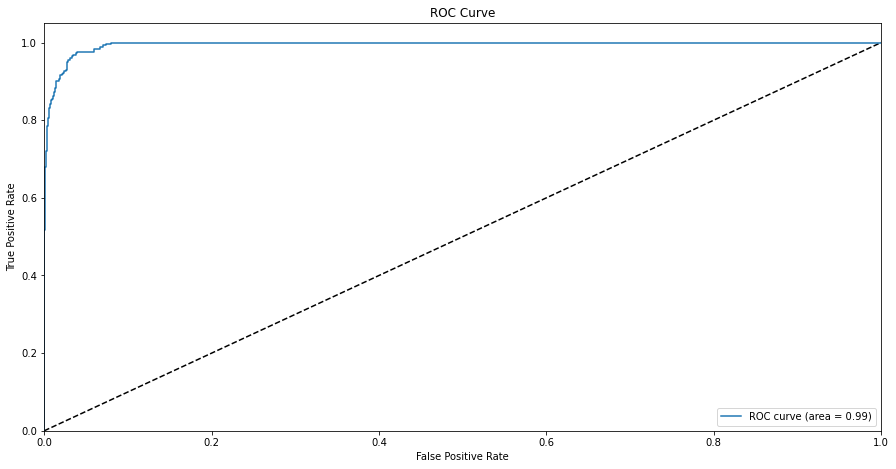

Tuned Hyperparameter(s): {'C': 0.003792690190732246, 'penalty': 'l2'}
Tuned Accuracy Score: 0.9789583333333333
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2116
         1.0       0.94      0.83      0.88       284

    accuracy                           0.97      2400
   macro avg       0.96      0.91      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [22]:
# Build model
logreg = LogisticRegression()
c_space = np.logspace(-10, 8, 20) # Covers a WIDE range of possinle C values
logreg_param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

train_test_model(X, y, logreg, logreg_param_grid)

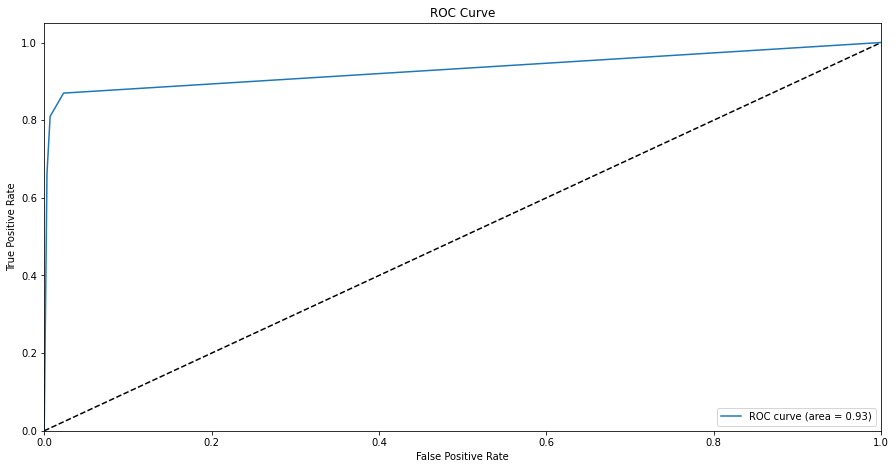

Tuned Hyperparameter(s): {'n_neighbors': 3}
Tuned Accuracy Score: 0.9722916666666667
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      2116
         1.0       0.94      0.81      0.87       284

    accuracy                           0.97      2400
   macro avg       0.96      0.90      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [23]:
# Build K Neigbors model
knn = KNeighborsClassifier()
N = [1,2,3,4,5,6,7]
knn_param_grid = {'n_neighbors': N}
train_test_model(X, y, knn, knn_param_grid)

In [ ]:
# Build Random Forest model
forest = RandomForestClassifier()
forest_param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": range(10,500,20),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
train_test_model(X, y, forest, forest_param_grid)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=32)

best_model = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=None, max_features=3, min_samples_split=250)
best_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features=3, min_samples_split=250)

In [25]:
# Explore feature importances
features = pd.DataFrame(best_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
features

,importance
activity_age,0.988149
org_id,0.005184
creation_source_PERSONAL_PROJECTS,0.002482
invited_by_user_id,0.002267
creation_source_GUEST_INVITE,0.000622
creation_source_SIGNUP_GOOGLE_AUTH,0.000388
creation_source_ORG_INVITE,0.000273
opted_in_to_mailing_list,0.000240
enabled_for_marketing_drip,0.000218
creation_source_SIGNUP,0.000178


### Plot active users

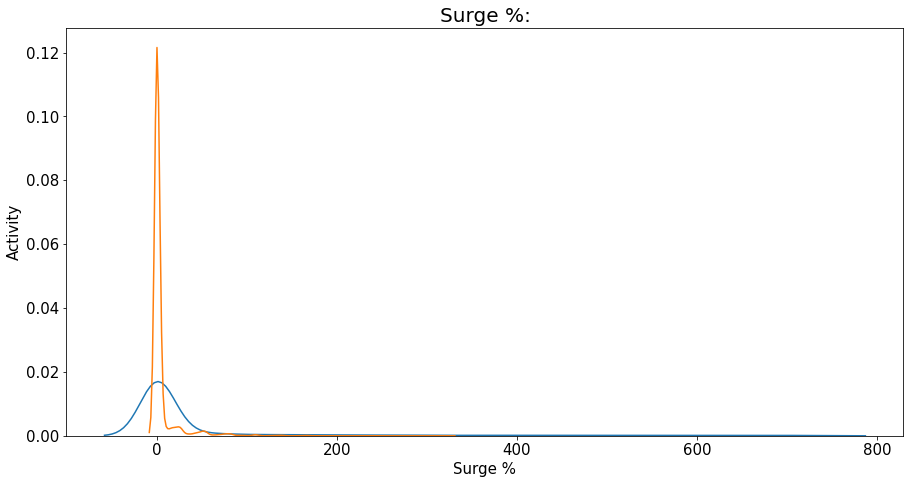

In [26]:
non_active = df_clean_ml[df_clean_ml['adopted']==0]

sns.distplot(df_clean_ml['activity_age'], hist=False, kde_kws={"label": "Active Users"});
sns.distplot(non_active['activity_age'], hist=False, kde_kws={"label": "Non-Active Users"});
plt.title('Surge %:', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("Surge %", size=15)
plt.ylabel('Activity', size=15)
plt.show()